# Handwriting recognition

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
import time

## Data import and visualization

Import the MNIST train dataset ([https://en.wikipedia.org/wiki/MNIST_database](https://en.wikipedia.org/wiki/MNIST_database))

In [ ]:
# This dataset is contained in the sample data directory of Google Colab online runtimes
data = np.genfromtxt('sample_data/mnist_train_small.csv', delimiter=',')
data.shape

(20000, 785)

Store the data in a matrix and the labels in a vector.

**REMARK**: in this lab we will work with features/classes on rows and samples on columns.

In [ ]:
labels = data[:,0]
x_data = data[:,1:].transpose() / 255
labels.shape, x_data.shape

((20000,), (784, 20000))

Visualize the first 30 pictures with the corresponding labels

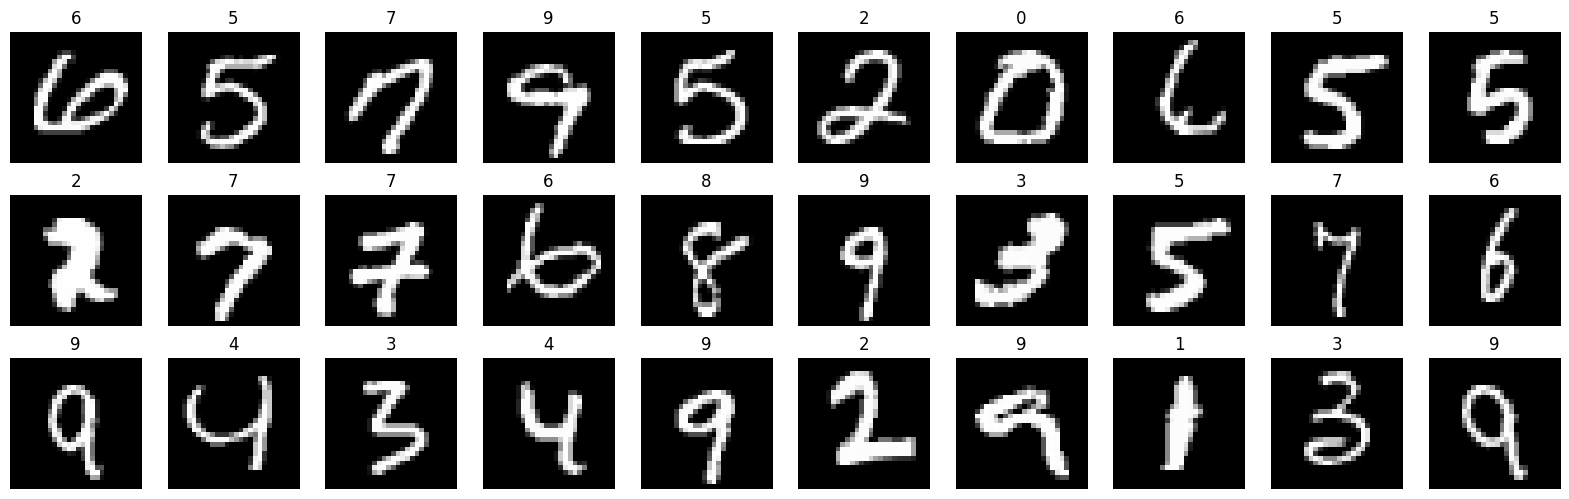

In [ ]:
fig, axs = plt.subplots(ncols = 10, nrows = 3, figsize = (20,6))
axs = axs.reshape((-1,))
for i in range(30):
  image_i = x_data[:,i].reshape((28,28))
  axs[i].imshow(image_i, cmap='gray')
  axs[i].set_title(int(labels[i]))
  axs[i].axis('off')

Create a [one-hot](https://en.wikipedia.org/wiki/One-hot) representation of the labels, that is a matrix where each row corresponds to a class (i.e. a digit).
the entries of the matrix are 1 if the sample corresponds to that digit, 0 otherwise.

In [ ]:
y_data = np.zeros((10, 20000))
for i in range(10):
  y_data[i, labels==i] = 1

Check that the matrix has exactly one element "1" in each column.

In [ ]:
row_sums = np.sum(y_data, axis = 0)
row_sums.min(), row_sums.max()

(1.0, 1.0)

## ANN training

Write a function to initialize the parameters (with Glorot Normal initialization) and a function implementing a feedforward ANN.

To the last layer of the ANN, apply a *soft-max* layer. If $z_1, \dots, z_n$ are the activations of the last layer neurons, the soft-max layer produces $\hat{z}_1, \dots, \hat{z}_n$, defined as
$$
\hat{z}_i = \frac{e^{z_i}}{\sum_{j=1}^n e^{z_j}}
$$
In this manner the outputs of the ANN satisfy by construction:
- $\hat{z}_i \in [0,1]$
- $\sum_{j=1}^n \hat{z}_j = 1$

Therefore, they can be intepreted as probabilities.

When the ANN will be trained, we will take the digit corresponding the the hightest proabability as prediction of the model.

In [ ]:
def initialize_params(layers_size):
  np.random.seed(0) # for reproducibility
  params = list()
  for i in range(len(layers_size) - 1):
    W = np.random.randn(layers_size[i+1], layers_size[i]) * np.sqrt(2 / (layers_size[i+1] + layers_size[i]))
    b = np.zeros((layers_size[i+1], 1))
    params.append(W)
    params.append(b)
  return params

activation = jnp.tanh

def ANN(x, params):
  layer = x
  num_layers = int(len(params) / 2 + 1)
  weights = params[0::2]
  biases = params[1::2]
  for i in range(num_layers - 1):
    layer = jnp.dot(weights[i], layer) - biases[i]
    if i < num_layers - 2:
      layer = activation(layer)
  layer_exp = jnp.exp(layer)
  layer = layer_exp / jnp.sum(layer_exp, axis = 0)
  return layer

Test the ANN and check that the above properties are satisfied.

In [ ]:
params = initialize_params([784, 20, 10])
y_predict = ANN(x_data, params)
y_sum = jnp.sum(y_predict, axis = 0)
jnp.min(y_predict), jnp.max(y_predict), jnp.min(y_sum), jnp.max(y_sum)

(Array(0.01172495, dtype=float32),
 Array(0.34660673, dtype=float32),
 Array(0.99999976, dtype=float32),
 Array(1.0000002, dtype=float32))

In [ ]:
y_predict.shape, y_sum.shape

((10, 20000), (20000,))

Implement the following metrics:
- mean square error
- cross entropy
- accuracy (fraction of samples correctly classified)

In [ ]:
def MSE(x, y, params):
  error =  ANN(x, params) - y
  return jnp.mean(error * error)

def cross_entropy(x, y, params):
  y_predict = ANN(x, params)
  return -jnp.mean(jnp.sum(jnp.log(y_predict)*y, axis = 0))

def accuracy(x, y, params):
  labels_predicted = jnp.argmax(ANN(x, params), axis = 0)
  labels = jnp.argmax(y, axis = 0)
  return jnp.mean(labels_predicted == labels)

print('MSE:       %f' % MSE(x_data, y_data, params))
print('X entropy: %f' % cross_entropy(x_data, y_data, params))
print('accuracy:  %f' % accuracy(x_data, y_data, params))

MSE:       0.091103
X entropy: 2.361587
accuracy:  0.110050


Put 10000 images in the training set and 10000 images in the validation set.

In [ ]:
n_train = 10000
n_valid = 10000
x_train = x_data[:,:n_train]
y_train = y_data[:,:n_train]
x_valid = x_data[:,-n_valid:]
y_valid = y_data[:,-n_valid:]

Run this cell. We will use it later.

In [ ]:
from IPython import display

class Callback:
  def __init__(self, refresh_rate = 250):
    self.refresh_rate = refresh_rate
    self.fig, self.axs = plt.subplots(1, figsize=(16,8))
    self.epoch = 0
    self.__call__(-1)

  def __call__(self, epoch):
    self.epoch = epoch
    if (epoch + 1) % self.refresh_rate == 0:
      self.draw()
      display.clear_output(wait=True)
      display.display(plt.gcf())
      time.sleep(1e-16)

  def draw(self):
    if self.epoch > 0:
      self.axs.clear()
      epochs = np.arange(1,len(history_train_Xen) + 1)
      self.axs.loglog(epochs, history_train_Xen, label = 'train_Xen')
      self.axs.loglog(epochs, history_valid_Xen, label = 'valid_Xen')
      self.axs.loglog(epochs, history_valid_MSE, label = 'valid_MSE')
      self.axs.loglog(epochs, history_valid_acc, label = 'valid_acc')

      self.axs.legend()
      self.axs.set_title('epoch %d - accuracy %0.1f%%' % (self.epoch + 1, 100*history_valid_acc[-1]))

Train an ANN-based classifier with two hidden layers with 50 neurons each.
Use 500 epochs of the RMSProp algorithm, with decay rate 0.9 and $\delta = 10^{-7}$ and fixed learning rate $\lambda = 0.002$. Use minibatches with batch size of 1000.
To monitor training, store every 10 training epochs the following metrics in the following lists:
- `history_train_Xen`: cross-entropy (training set)
- `history_valid_Xen`: cross-entropy (validation set)
- `history_valid_MSE`: MSE (validation set)
- `history_valid_acc`: accuracy (validation set)

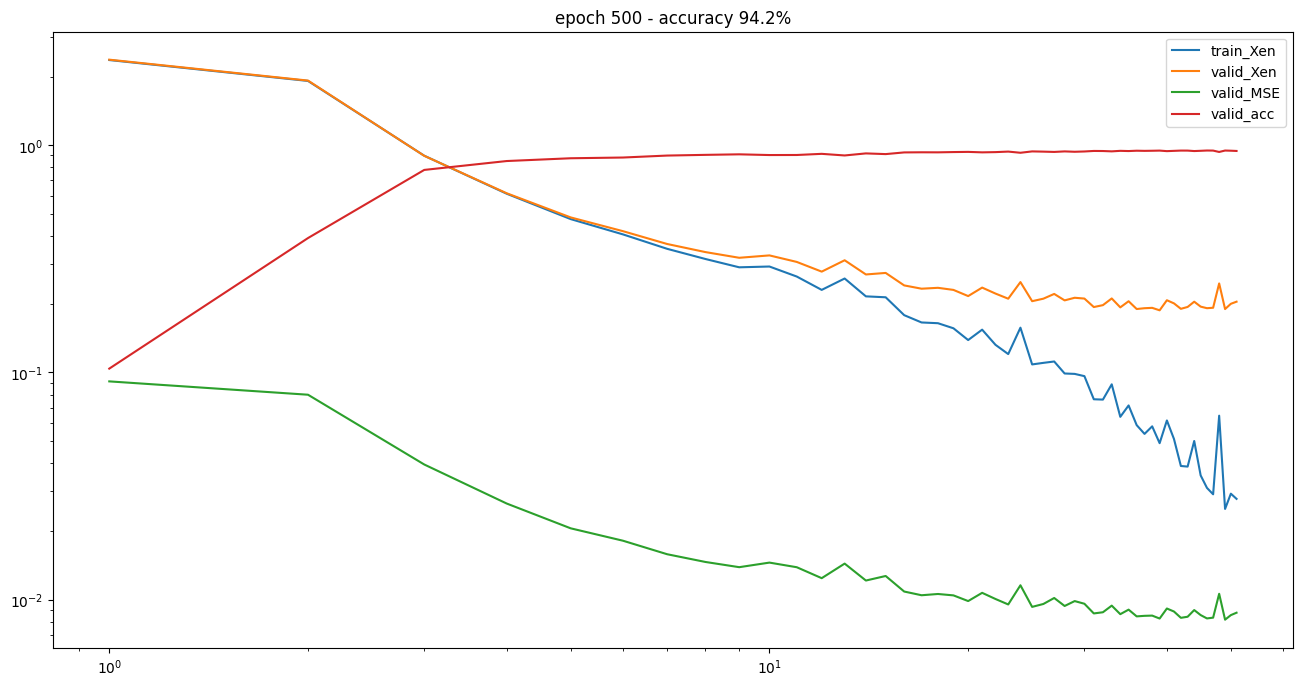

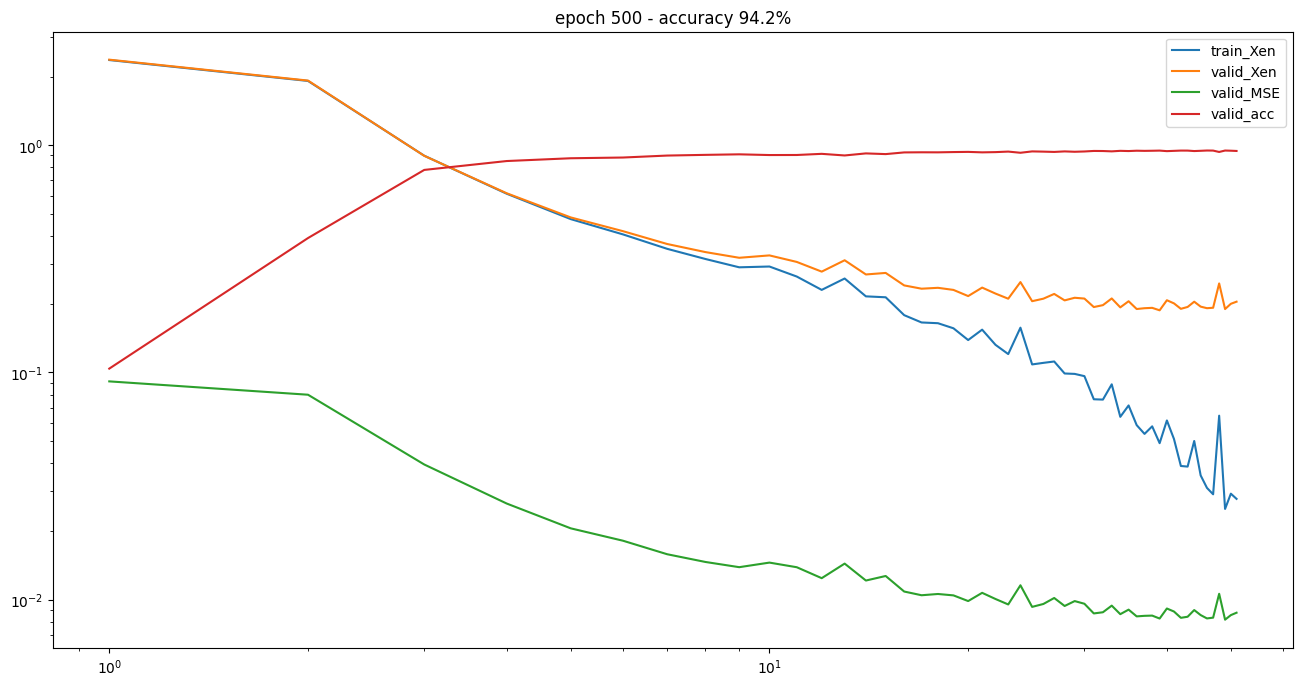

In [ ]:
# Hyperparameters
layers_size = [784, 50, 50, 10]
# Training options
num_epochs = 500
batch_size = 1000
learning_rate = 2e-3
decay_rate = .9
delta = 1e-7
########################################

params = initialize_params(layers_size)

grad = jax.grad(cross_entropy, argnums = 2)
grad_jit = jax.jit(grad)

cross_entropy_jit = jax.jit(cross_entropy)
MSE_jit = jax.jit(MSE)
accuracy_jit = jax.jit(accuracy)

history_train_Xen = list()
history_valid_Xen = list()
history_valid_MSE = list()
history_valid_acc = list()
def dump():
  history_train_Xen.append(cross_entropy_jit(x_train, y_train, params))
  history_valid_Xen.append(cross_entropy_jit(x_valid, y_valid, params))
  history_valid_MSE.append(MSE_jit(x_valid, y_valid, params))
  history_valid_acc.append(accuracy_jit(x_valid, y_valid, params))

dump()
cb = Callback(refresh_rate = 50)

cumulated_square_grad = [0.0 for i in range(len(params))]
for epoch in range(num_epochs):
  # learning_rate = max(learning_rate_min, learning_rate_max * (1 - epoch/learning_rate_decay))
  idxs = np.random.choice(n_train, batch_size)
  grads = grad_jit(x_train[:,idxs], y_train[:,idxs], params)

  for i in range(len(params)):
    cumulated_square_grad[i] = decay_rate*cumulated_square_grad[i] + (1 - decay_rate) * grads[i] * grads[i]
    params[i] -= learning_rate / (delta + jnp.sqrt(cumulated_square_grad[i])) * grads[i]

  if epoch % 10 == 0: dump()

  cb(epoch)
cb.draw()

## Testing

Load the dataset `sample_data/mnist_test.csv` and compute the accuracy of the classifier on this dataset.

In [ ]:
data_test = np.genfromtxt('sample_data/mnist_test.csv', delimiter=',')
data_test.shape
labels_test = data_test[:,0]
x_test = data_test[:,1:].transpose() / 255
y_test = np.zeros((10, x_test.shape[1]))
for i in range(10):
  y_test[i, labels_test==i] = 1
x_test.shape, y_test.shape

((784, 10000), (10, 10000))

In [ ]:
acc = accuracy(x_test, y_test, params)
print('accuracy: %f%%' % (100*acc))

accuracy: 94.900002%


Use the following script to visualize the predictions on a bunch of test images.

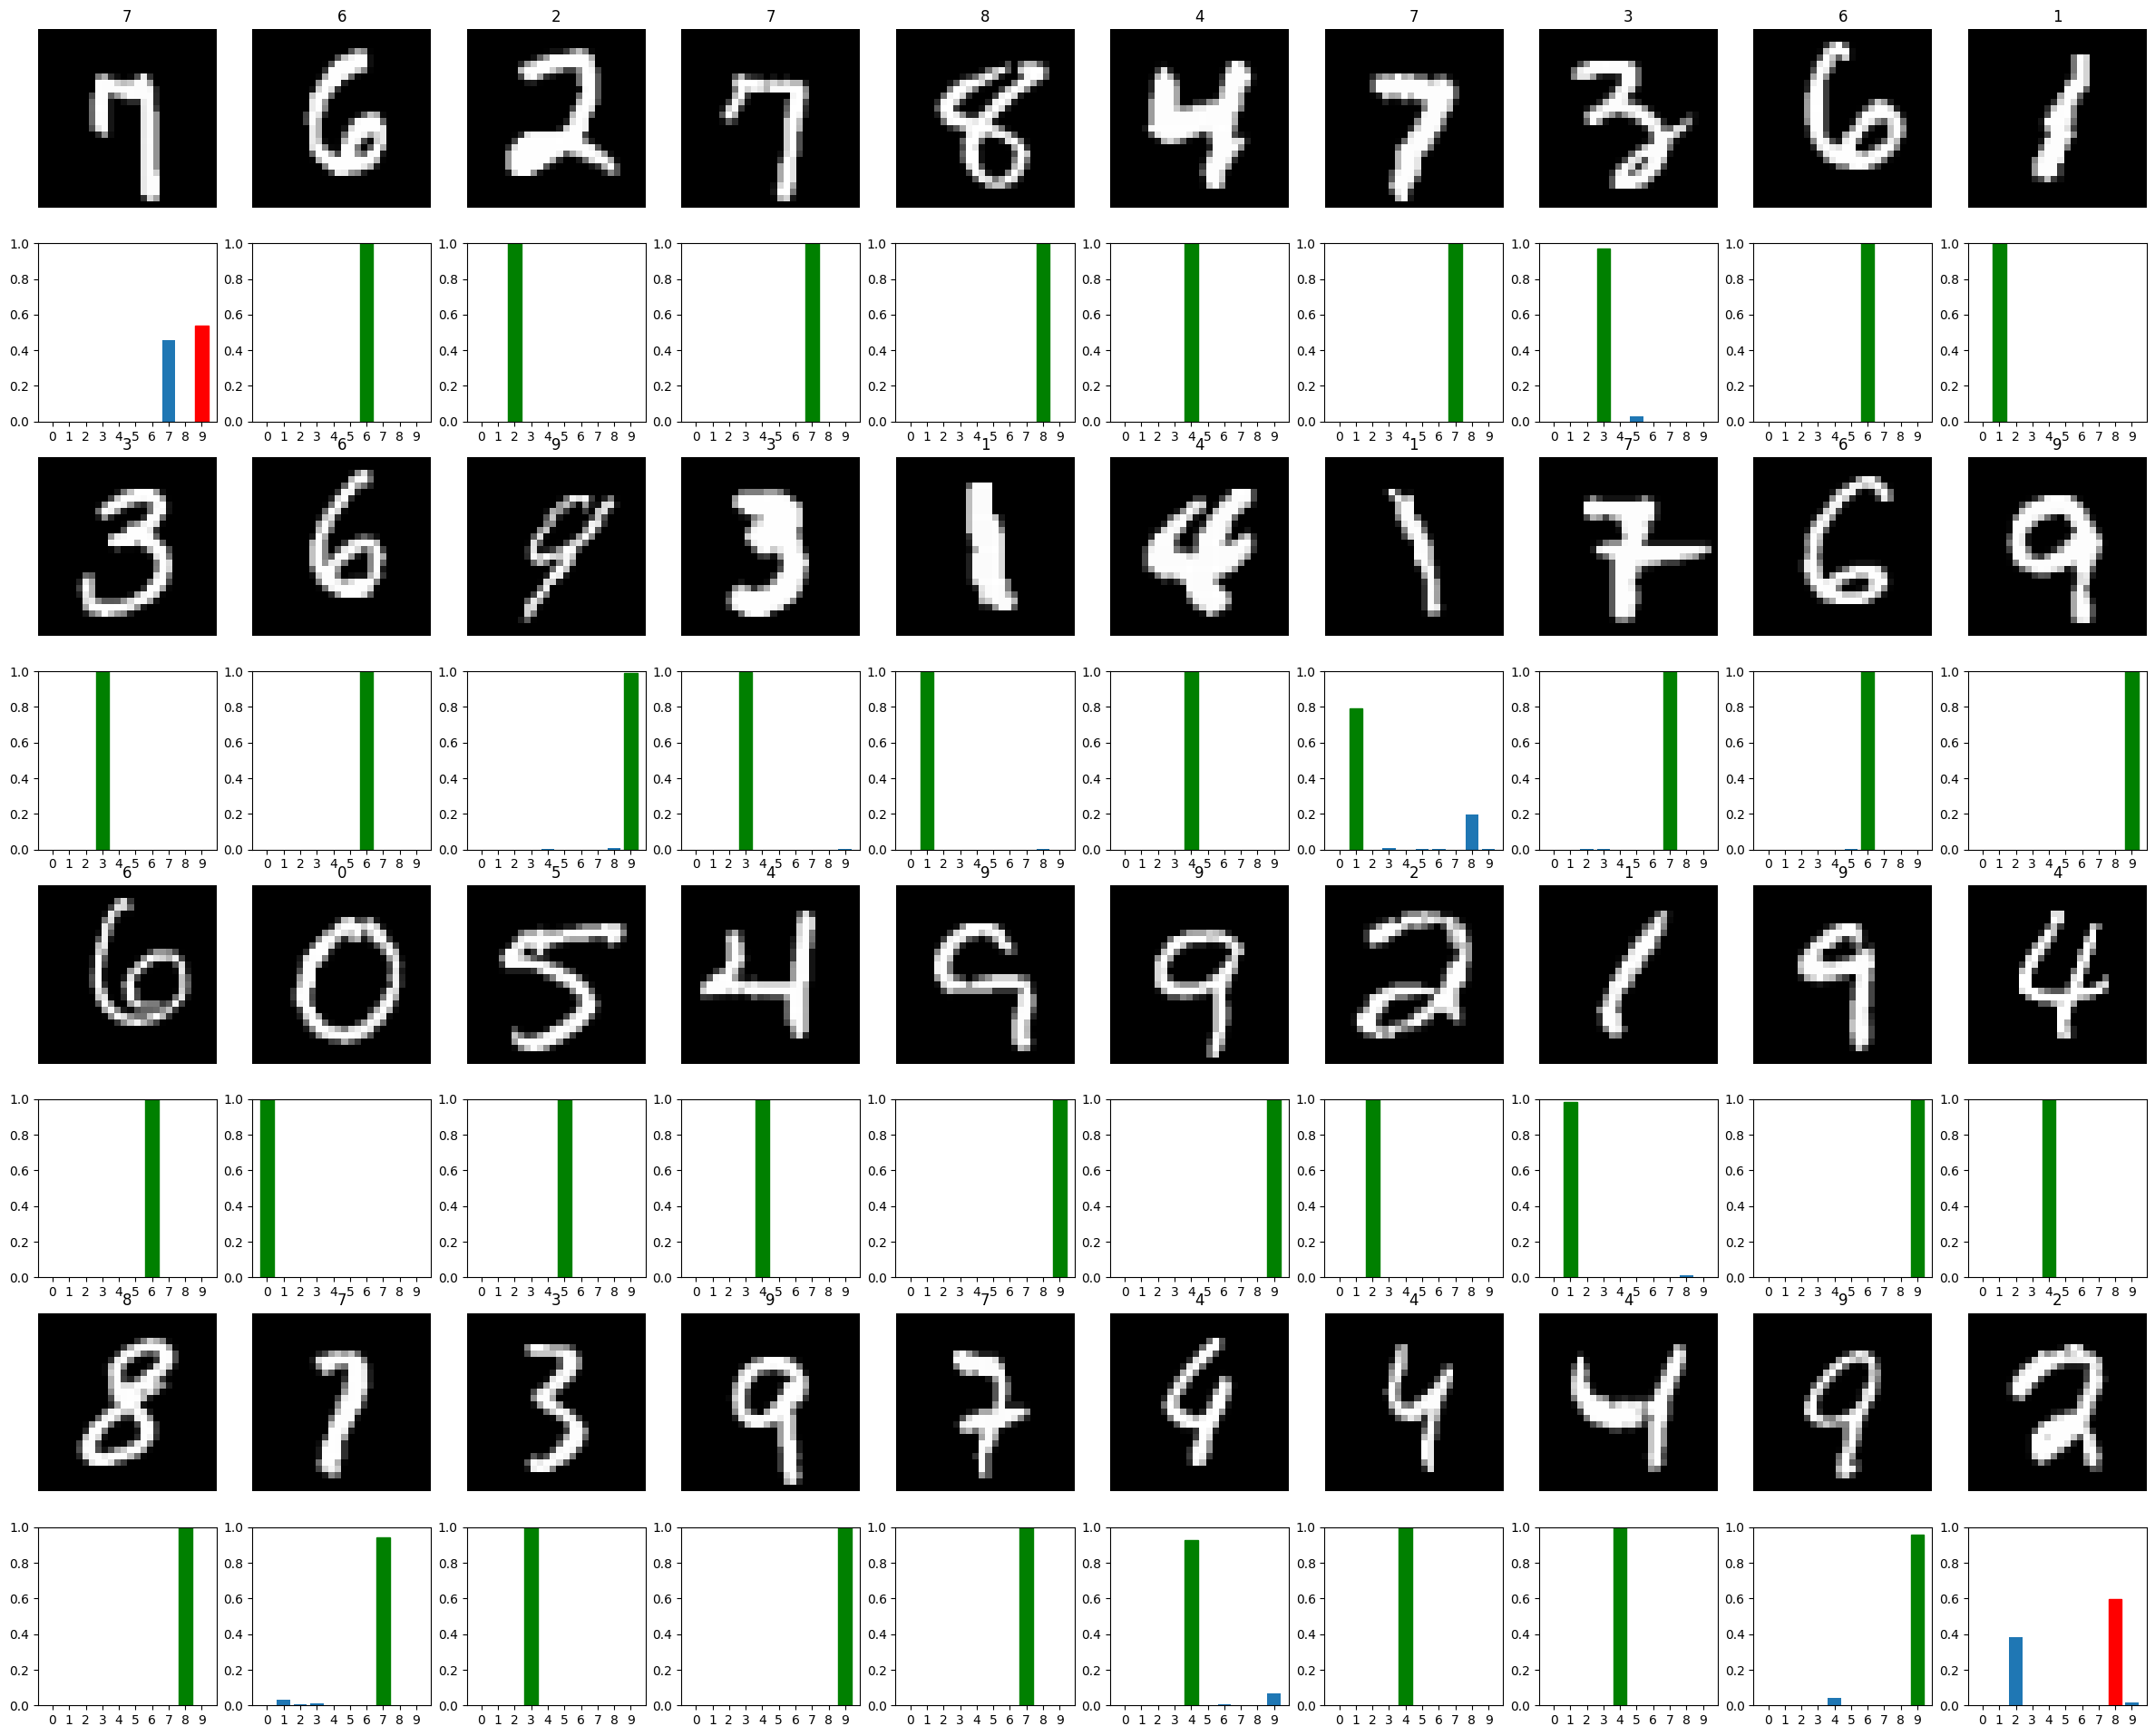

In [ ]:
offset = 80
n_images = 40

images_per_row = 10
y_predicted = ANN(x_test[:,offset:offset+n_images], params)

def draw_bars(ax, y_predicted, label):
    myplot = ax.bar(range(10), (y_predicted))
    ax.set_ylim([0,1])
    ax.set_xticks(range(10))

    label_predicted = np.argmax(y_predicted)
    if label == label_predicted:
      color = 'green'
    else:
      color = 'red'
    myplot[label_predicted].set_color(color)

import math
n_rows = 2 * math.ceil(n_images / images_per_row)
_, axs = plt.subplots(n_rows, images_per_row, figsize = (3*images_per_row, 3*n_rows))
row = 0
col = 0
for i in range(n_images):
  axs[2*row,col].imshow(x_test[:,offset+i].reshape((28,28)), cmap='gray')
  axs[2*row,col].set_title(int(labels_test[offset+i]))
  axs[2*row,col].axis('off')

  draw_bars(axs[2*row+1,col], y_predicted[:,i], labels_test[offset+i])

  col += 1
  if col == images_per_row:
    col = 0
    row += 1


# Adversarial attacks

You have trained your classifier. Cool, isn't it? Let us now try to fool it.

Consider the last image of the training set. Visualize it and visualize the associated predictions of the classifier.

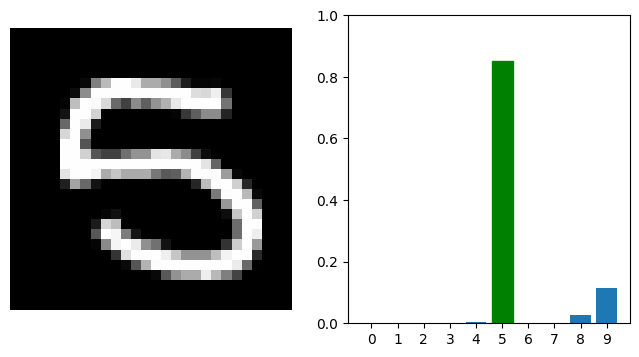

In [ ]:
x = x_data[:,-1][:,None]
y = y_data[:,-1][:,None]
label = np.argmax(y)

_, axs = plt.subplots(1,2, figsize = (8,4))
axs[0].imshow(x.reshape((28,28)), cmap = 'gray')
axs[0].axis('off')

y_pred = ANN(x, params)

draw_bars(axs[1], y_pred[:,0], label)

An adversarial attack consists of an (almost imperceptible) modification of the image, aimed at fooling the classifier into making a mistake.
See e.g. [this article](https://www.wired.com/story/tesla-speed-up-adversarial-example-mgm-breach-ransomware/)

To hack the classifier, compute the gradient of cross entropy loss funcion with respect to the input (not to the parameters!). Then, superimpose a multiple of the gradient to the original image.

Visualize the original and the hacked images and the corresponding prediction of the classifier.

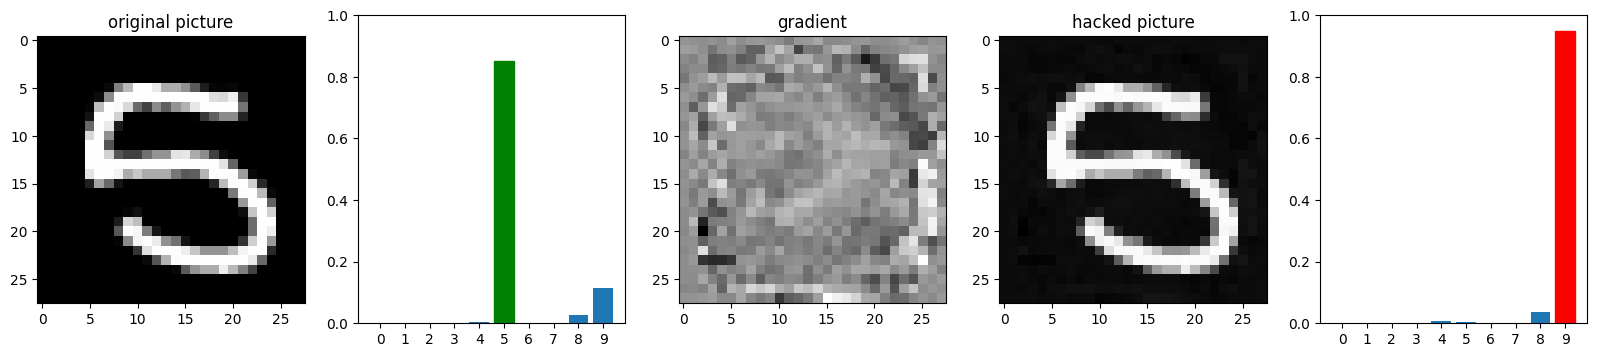

In [ ]:
grad = jax.grad(cross_entropy, argnums = 0)
gradient = grad(x, y, params)
x_updated = x + 0.1*gradient
y_updated = ANN(x_updated, params)

_, axs = plt.subplots(1,5,figsize=(20,4))
axs[0].imshow(x.reshape((28,28)), cmap = 'gray')
axs[0].set_title('original picture')
draw_bars(axs[1], y_pred[:,0], label)
axs[2].imshow(gradient.reshape((28,28)), cmap = 'gray')
axs[2].set_title('gradient')
axs[3].imshow(x_updated.reshape((28,28)), cmap = 'gray')
axs[3].set_title('hacked picture')
draw_bars(axs[4], y_updated[:,0], label)

# Using PCA for feature selection

Perform the Principal Component Analysis of the training dataset, plotting the trend of the singular values.

(-0.5, 27.5, 27.5, -0.5)

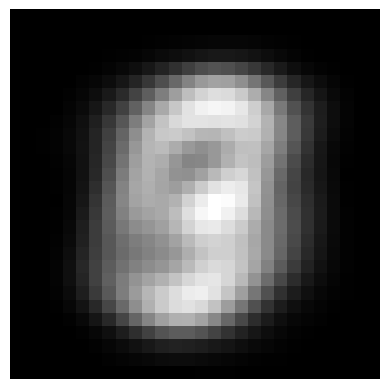

In [ ]:
x_train_mean = x_train.mean(axis = 1)
plt.imshow(x_train_mean.reshape((28,28)), cmap = 'gray')
plt.axis('off')

Text(0.5, 1.0, 'Explained variance')

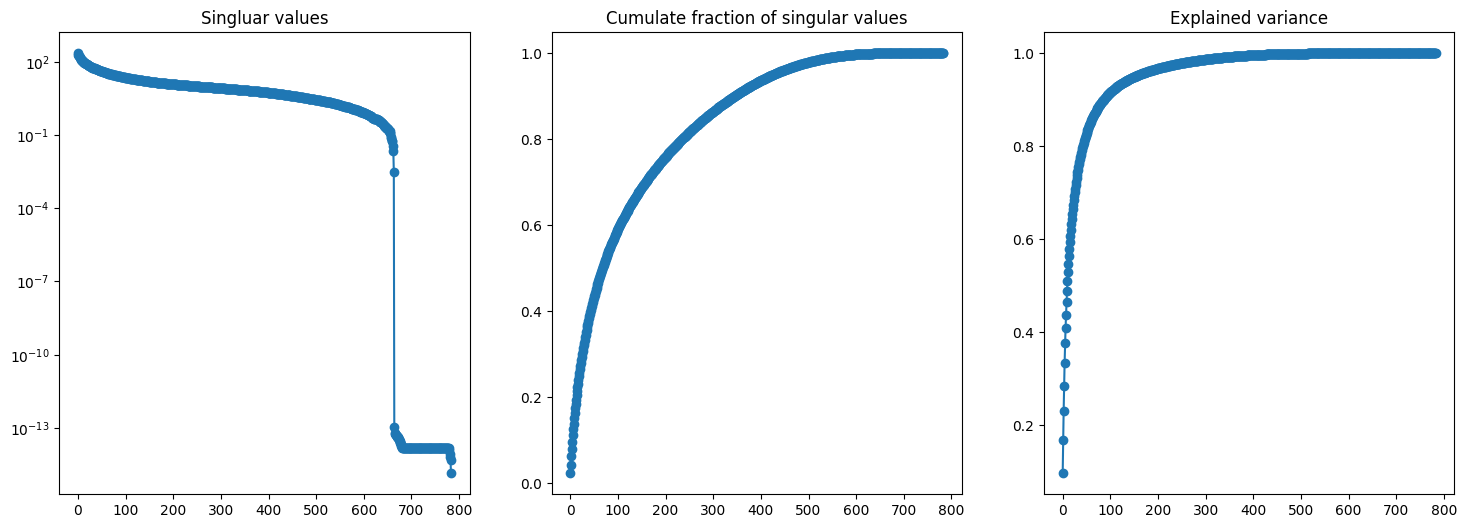

In [ ]:
U, s, VT = np.linalg.svd(x_train - x_train_mean[:,None], full_matrices = False)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (18,6))

axes[0].semilogy(s, 'o-')
axes[0].set_title('Singluar values')

axes[1].plot(np.cumsum(s)/np.sum(s), 'o-')
axes[1].set_title('Cumulate fraction of singular values')

axes[2].plot(np.cumsum(s**2)/np.sum(s**2), 'o-')
axes[2].set_title('Explained variance')

Compute the principal components associated with the training and validation datasets and put them in two matrices.

In [ ]:
x_train_pc = np.matmul(U.transpose(), (x_train - x_train_mean[:,None]))
x_valid_pc = np.matmul(U.transpose(), (x_valid - x_train_mean[:,None]))

Train a classifier, providing as an input only the first 50 principal components of the data. Emply an ANN with a single 50-neurons hidden layer.

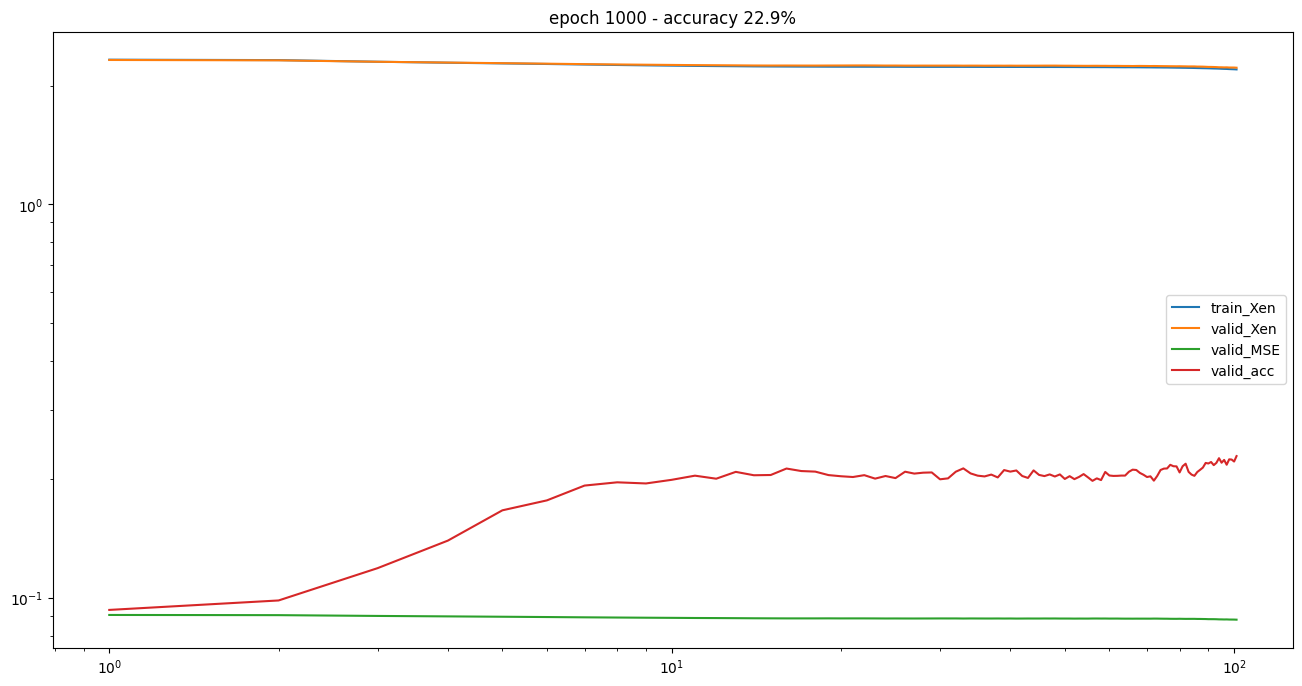

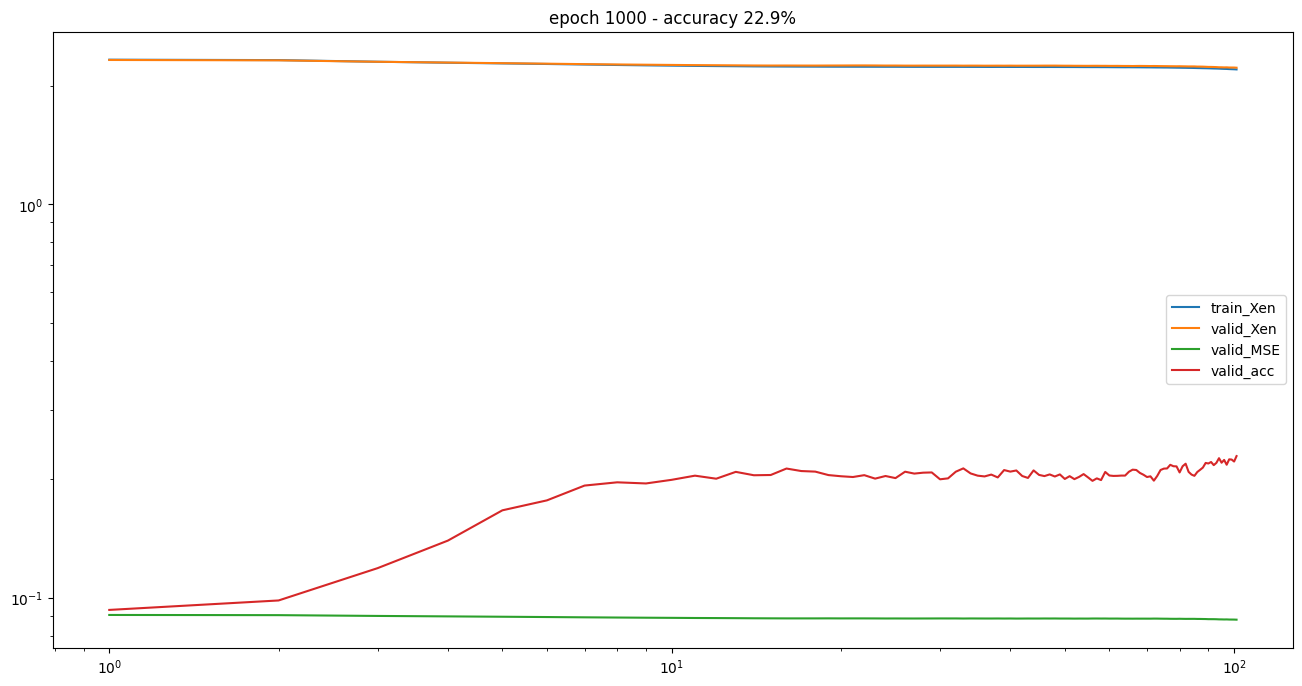

In [ ]:
# Hyperparameters
sv_offset = 100
n_sv = 50
layers_size = [n_sv, 50, 10]
# Training options
num_epochs = 1000
batch_size = 1000
learning_rate = 2e-3
decay_rate = .9
delta = 1e-7
########################################

params = initialize_params(layers_size)

grad = jax.grad(cross_entropy, argnums = 2)
grad_jit = jax.jit(grad)

cross_entropy_jit = jax.jit(cross_entropy)
MSE_jit = jax.jit(MSE)
accuracy_jit = jax.jit(accuracy)

history_train_Xen = list()
history_valid_Xen = list()
history_valid_MSE = list()
history_valid_acc = list()
def dump():
  history_train_Xen.append(cross_entropy_jit(x_train_pc[sv_offset:sv_offset+n_sv,:], y_train, params))
  history_valid_Xen.append(cross_entropy_jit(x_valid_pc[sv_offset:sv_offset+n_sv,:], y_valid, params))
  history_valid_MSE.append(MSE_jit(x_valid_pc[sv_offset:sv_offset+n_sv,:], y_valid, params))
  history_valid_acc.append(accuracy_jit(x_valid_pc[sv_offset:sv_offset+n_sv,:], y_valid, params))

dump()
cb = Callback(refresh_rate = 50)

cumulated_square_grad = [0.0 for i in range(len(params))]
for epoch in range(num_epochs):
  # learning_rate = max(learning_rate_min, learning_rate_max * (1 - epoch/learning_rate_decay))
  idxs = np.random.choice(n_train, batch_size)
  grads = grad_jit(x_train_pc[sv_offset:sv_offset+n_sv,idxs], y_train[:,idxs], params)

  for i in range(len(params)):
    cumulated_square_grad[i] = decay_rate*cumulated_square_grad[i] + (1 - decay_rate) * grads[i] * grads[i]
    params[i] -= learning_rate / (delta + jnp.sqrt(cumulated_square_grad[i])) * grads[i]

  if epoch % 10 == 0: dump()

  cb(epoch)
cb.draw()

Test the classifier on the test dataset.

In [ ]:
x_test_pc = np.matmul(U.transpose(), (x_test - x_train_mean[:,None]))
acc = accuracy(x_test_pc[sv_offset:sv_offset+n_sv], y_test, params)
print('accuracy: %f%%' % (100*acc))

accuracy: 65.580002%


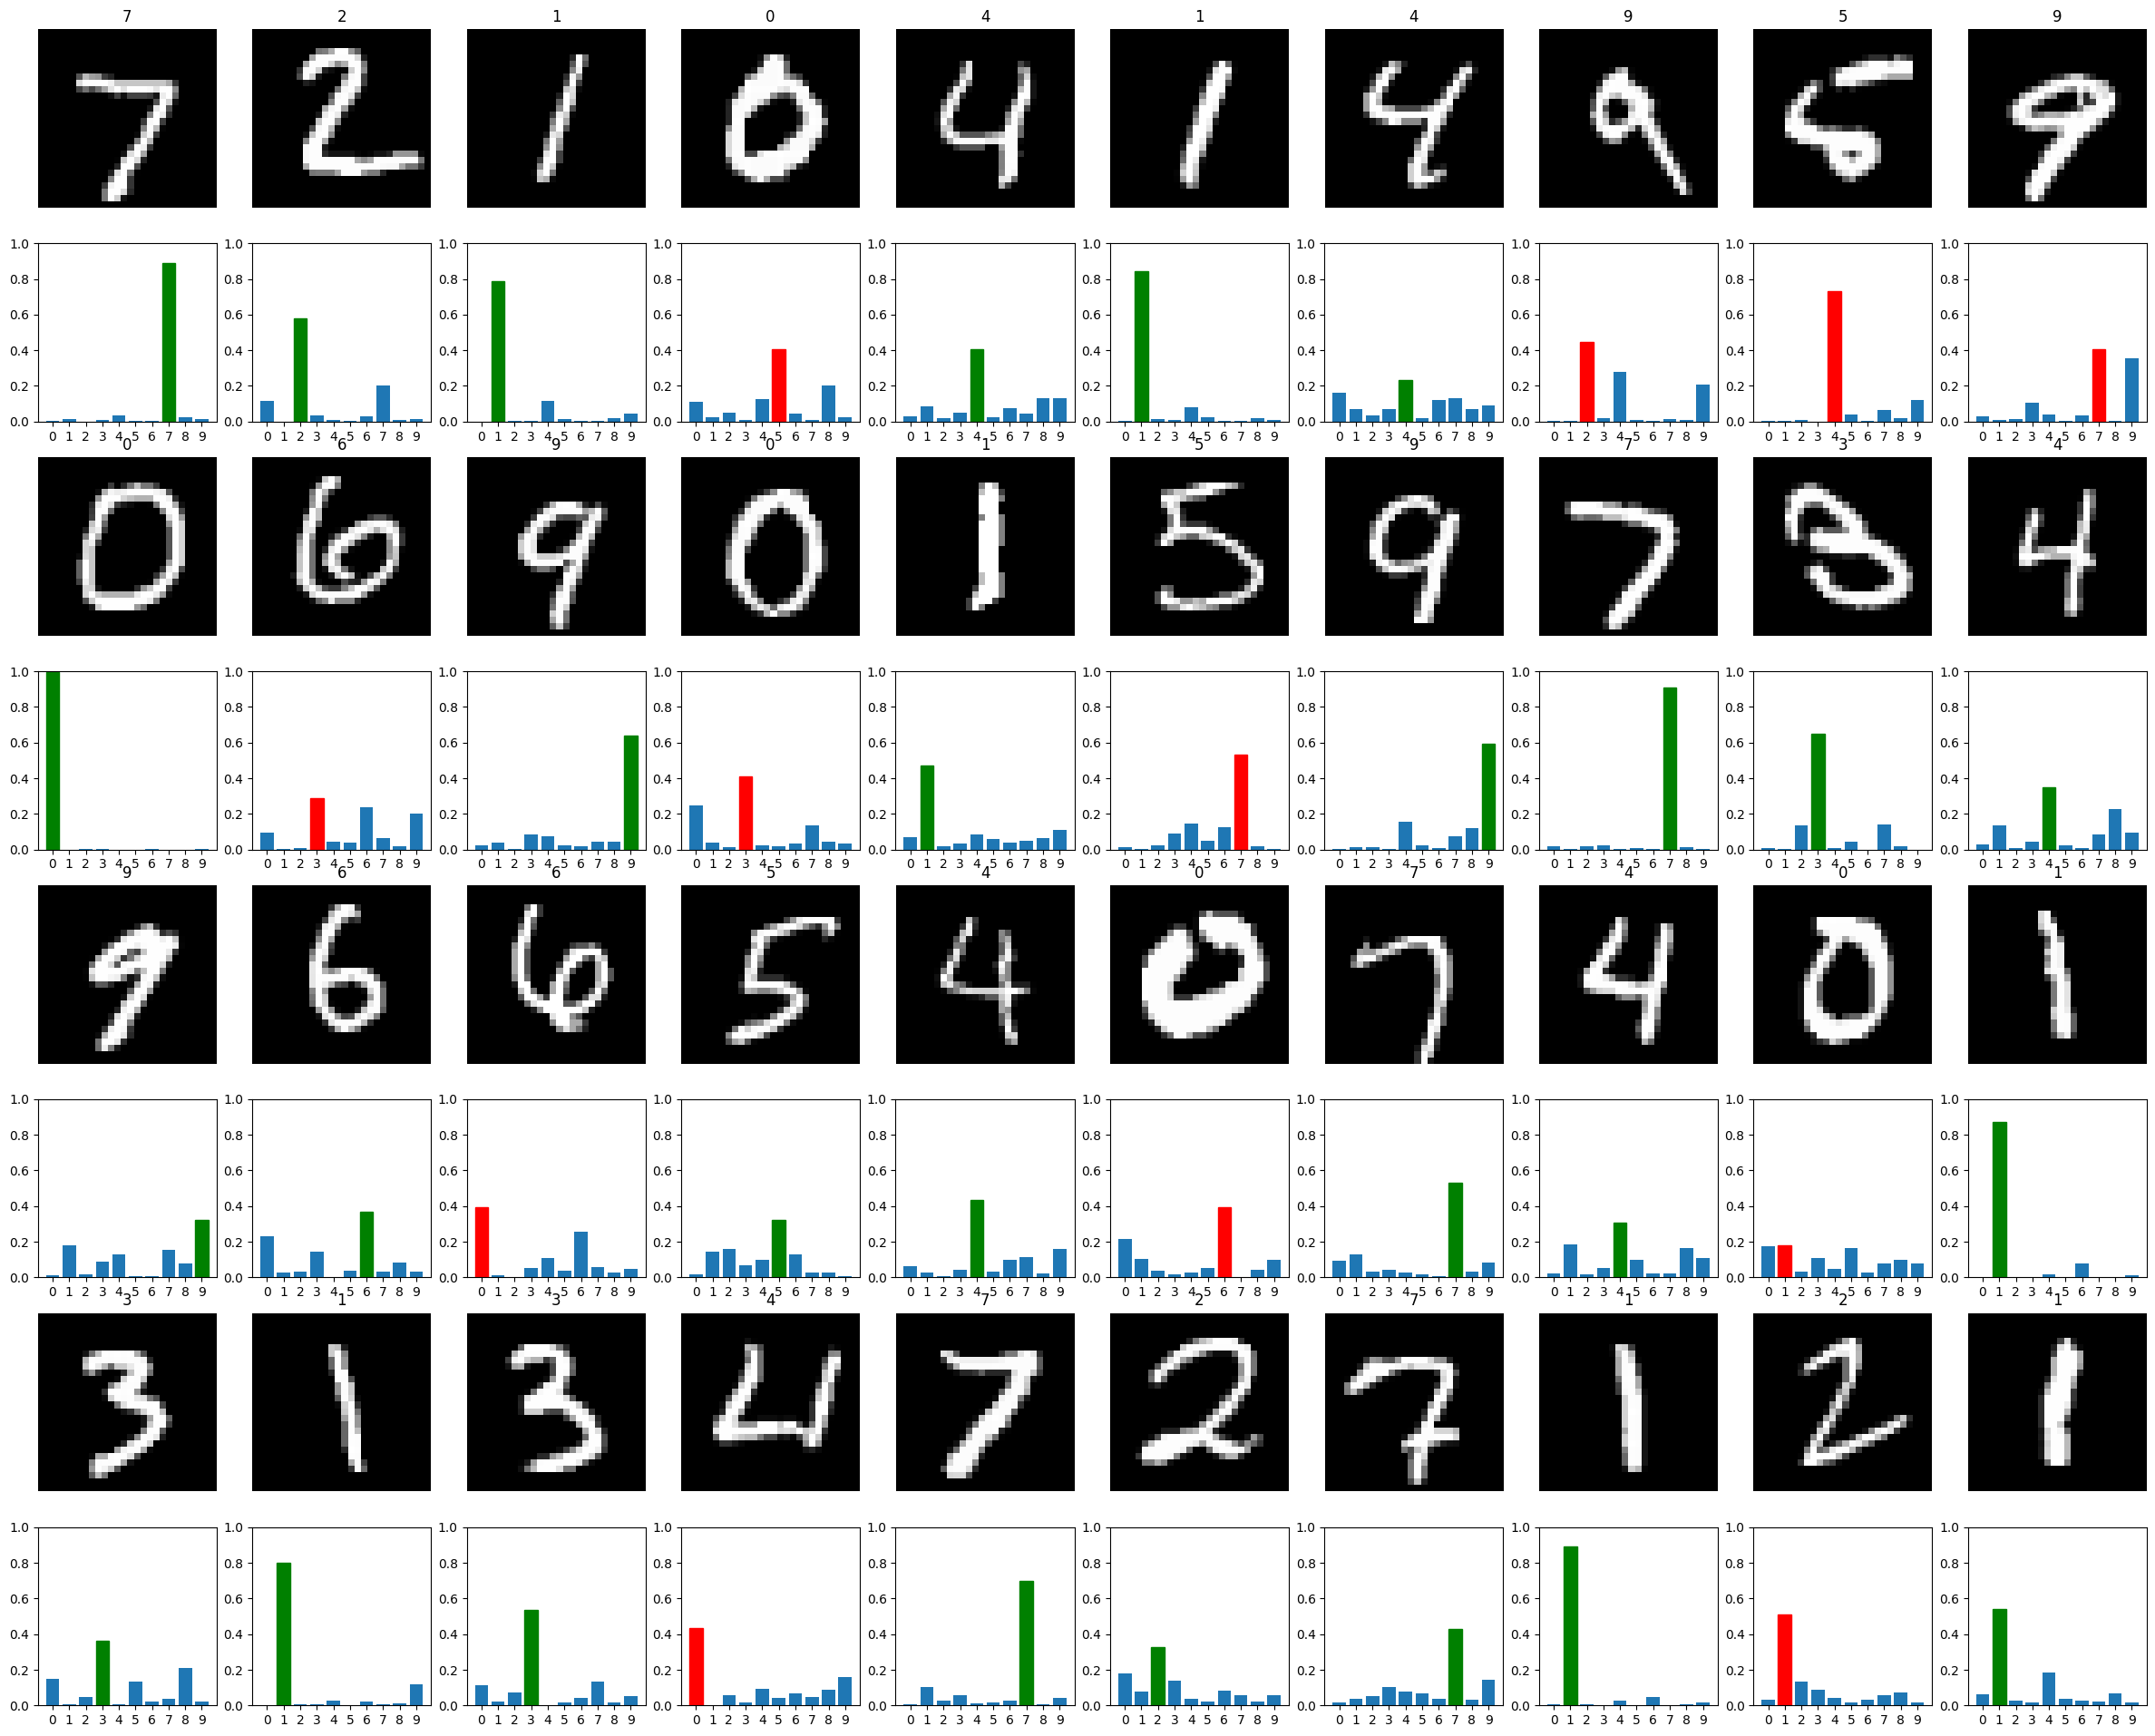

In [ ]:
offset = 0
n_images = 40

images_per_row = 10
y_predicted = ANN(x_test_pc[sv_offset:sv_offset+n_sv,offset:offset+n_images], params)

import math
n_rows = 2 * math.ceil(n_images / images_per_row)
_, axs = plt.subplots(n_rows, images_per_row, figsize = (3*images_per_row, 3*n_rows))
row = 0
col = 0
for i in range(n_images):
  axs[2*row,col].imshow(x_test[:,offset+i].reshape((28,28)), cmap='gray')
  axs[2*row,col].set_title(int(labels_test[offset+i]))
  axs[2*row,col].axis('off')

  draw_bars(axs[2*row+1,col], y_predicted[:,i], labels_test[offset+i])

  col += 1
  if col == images_per_row:
    col = 0
    row += 1

Repeat the previous point by employing a collection of 50 singular values, this time excluding the first $n$ of them.